# SMOTE Techniques for Class Imbalances

Based on [this article](https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/) by Jason Brownlee.

In [1]:
from collections import Counter
import matplotlib.pyplot as plt
from numpy import where, mean

from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE, SVMSMOTE, BorderlineSMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler

## 1 Introduction to SMOTE and Variations

### 1.1 Defining Dataset

We start by creating a dataset with a large class imbalance.
We will use this artificially created data throughout this notebook as an illustration.

In [2]:
# Create an aritificial, 2-dimensional dataset
X_orig, y_orig = make_classification(n_samples=10000, 
                                       n_features=2, 
                                       n_redundant=0,
                                       n_clusters_per_class=1,
                                       weights=[0.99], 
                                       flip_y=0,
                                       random_state=1)

Next, we define a function to plot our dataset. We will reuse this function throughout this notebook.

In [3]:
def plot_dataset(X, y, title="Dataset"):
    
    # Summarize class distribution
    counter = Counter(y)
    print(counter)
    
    for label, _ in counter.items():
        row_ix = where(y == label)[0]
        plt.scatter(X[row_ix, 0], X[row_ix, 1], label=str(label))

    plt.legend()
    plt.title(title)
    plt.xlabel("feature 1")
    plt.ylabel("feature 2")
    plt.grid()
    plt.show()

Counter({0: 9900, 1: 100})


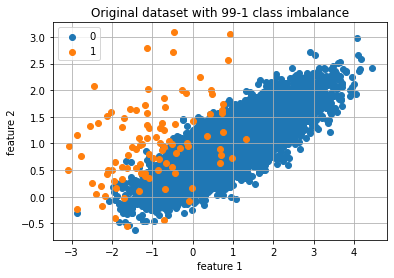

In [4]:
plot_dataset(X_orig, 
             y_orig, 
             title="Original dataset with 99-1 class imbalance")

### 1.2 SMOTE Fundamental Technique

Our original dataset has a 99-1 class imbalance. We can use the synthetic minority oversampling technique (SMOTE) to artificially sample new datapoints for the minority class. 

We create an oversampling object *oversample* and fit our original dataset to this oversampler.

Counter({0: 9900, 1: 9900})


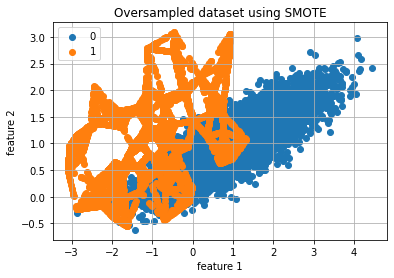

In [5]:
# Instantiate oversampler and apply to our dataset
oversample = SMOTE()
X_smote, y_smote = oversample.fit_resample(X_orig, y_orig)

plot_dataset(X_smote, 
             y_smote, 
             title="Oversampled dataset using SMOTE")

Note that we have oversampled the minority class such that it has the same number of samples as the majority class. The class balance is now 1-1.

### 1.3 SMOTE with Random Undersampling

In large class imbalances (such as this case), oversampling the minority class can sometimes yield worse results since the new samples do not necessarily correctly represent the minority class.

A solution is to only oversample the minority sample to less than the majority class, and then to undersample the majority class.

Counter({0: 1980, 1: 990})


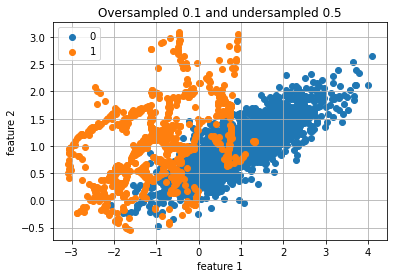

In [6]:
over = SMOTE(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

X, y = pipeline.fit_resample(X_orig, y_orig)
plot_dataset(X, y, title="Oversampled 0.1 and undersampled 0.5")

### 1.4 Borderline SMOTE

Counter({0: 9900, 1: 9900})


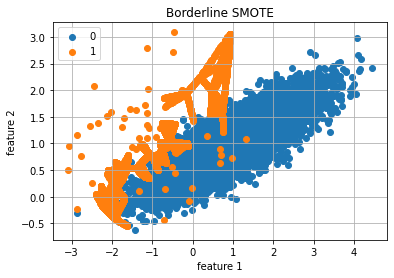

In [7]:
oversample = BorderlineSMOTE()
X, y = oversample.fit_resample(X_orig, y_orig)
plot_dataset(X, y, title="Borderline SMOTE")

### 1.5 Adaptive Synthetic Sampling (ADASYN)

Counter({0: 9900, 1: 9899})


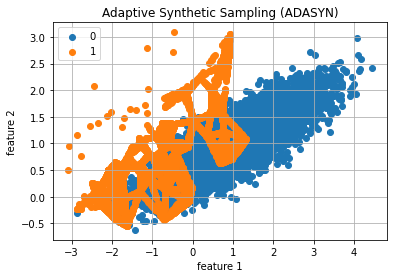

In [8]:
oversample = ADASYN()
X, y = oversample.fit_resample(X_orig, y_orig)
plot_dataset(X, y, title="Adaptive Synthetic Sampling (ADASYN)")

### 1.6 Borderline SMOTE with SVM

Counter({0: 9900, 1: 9900})


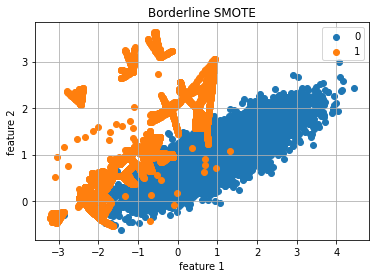

In [9]:
oversample = SVMSMOTE()
X, y = oversample.fit_resample(X_orig, y_orig)
plot_dataset(X, y, title="Borderline SMOTE")

## 2 Classification with SMOTE

Let us now evaluate how a classifier performs using these SMOTE variations.

### 2.1 Comparing a Basic Classifier to SMOTE Variations

In [10]:
# Define the cross-validation protocol
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# Evaluate using the original dataset
model = DecisionTreeClassifier()

scores = cross_val_score(model, X_orig, y_orig, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Original dataset:\nMean ROC AUC: %.3f \n\n' % mean(scores))

# Evaluate using SMOTE
steps = [('over', SMOTE()), ('model', model)]
pipeline = Pipeline(steps=steps)

scores = cross_val_score(pipeline, X_orig, y_orig, scoring='roc_auc', cv=cv, n_jobs=-1)
print('SMOTE dataset:\nMean ROC AUC: %.3f \n\n' % mean(scores))

# Evaluate over- and undersampling SMOTE 
over = SMOTE(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('over', over), ('under', under), ('model', model)]
pipeline = Pipeline(steps=steps)

scores = cross_val_score(pipeline, X_orig, y_orig, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Over- and undersampling dataset:\nMean ROC AUC: %.3f \n\n' % mean(scores))

# Evaluate over- and undersampling Borderline SMOTE 
over = BorderlineSMOTE(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('over', over), ('under', under), ('model', model)]
pipeline = Pipeline(steps=steps)

scores = cross_val_score(pipeline, X_orig, y_orig, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Borderline SMOTE Over- and undersampling dataset:\nMean ROC AUC: %.3f \n\n' % mean(scores))

# Evaluate over- and undersampling SVM-SMOTE 
over = SVMSMOTE(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('over', over), ('under', under), ('model', model)]
pipeline = Pipeline(steps=steps)

scores = cross_val_score(pipeline, X_orig, y_orig, scoring='roc_auc', cv=cv, n_jobs=-1)
print('SVM-SMOTE Over- and undersampling dataset:\nMean ROC AUC: %.3f \n\n' % mean(scores))

# Evaluate over- and undersampling ADASYN SMOTE 
over = ADASYN(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('over', over), ('under', under), ('model', model)]
pipeline = Pipeline(steps=steps)

scores = cross_val_score(pipeline, X_orig, y_orig, scoring='roc_auc', cv=cv, n_jobs=-1)
print('ADASYN Over- and undersampling dataset:\nMean ROC AUC: %.3f \n' % mean(scores))

Original dataset:
Mean ROC AUC: 0.772 


SMOTE dataset:
Mean ROC AUC: 0.813 


Over- and undersampling dataset:
Mean ROC AUC: 0.848 


Borderline SMOTE Over- and undersampling dataset:
Mean ROC AUC: 0.845 


SVM-SMOTE Over- and undersampling dataset:
Mean ROC AUC: 0.849 


ADASYN Over- and undersampling dataset:
Mean ROC AUC: 0.839 



### 2.2 Evaluate Various k-values of SMOTE

SMOTE uses the $k$-NN algorithm to synthesize new data points. Hence, we can adjust the SMOTE algorithm for various $k$ values.

In [11]:
for k in range(1,10):
    
    # define pipeline
    model = DecisionTreeClassifier()
    over = SMOTE(sampling_strategy=0.1, k_neighbors=k)
    under = RandomUnderSampler(sampling_strategy=0.5)
    steps = [('over', over), ('under', under), ('model', model)]
    pipeline = Pipeline(steps=steps)
    
    # evaluate pipeline
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(pipeline, 
                             X_orig, 
                             y_orig, 
                             scoring='roc_auc', 
                             cv=cv, 
                             n_jobs=-1)
    score = mean(scores)
    print('  k=%d, Mean ROC AUC: %.3f' % (k, score))

  k=1, Mean ROC AUC: 0.826
  k=2, Mean ROC AUC: 0.834
  k=3, Mean ROC AUC: 0.826
  k=4, Mean ROC AUC: 0.837
  k=5, Mean ROC AUC: 0.836
  k=6, Mean ROC AUC: 0.853
  k=7, Mean ROC AUC: 0.848
  k=8, Mean ROC AUC: 0.854
  k=9, Mean ROC AUC: 0.855
